# Parameter Optimization

Import necessary libraries

In [1]:
# -*- coding: utf-8 -*-
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys

sys.path.append('E:/GitHub/DigitalTwinInjectionMolding/')

from DIM.models.model_structures import MLP
from DIM.optim.param_optim import HyperParameterPSO,ModelParameterEstimation,ModelTraining

In the following the different possibilities of identifying models from data offered by the toolbox are illustrated. 

To begin with, data from a nonlinear system in state space represenation is gathered. Over all, 10 experiments (batches) are conducted, each of which has a length of $N=100$ time steps:

## Generate Identification Data

In [2]:
N = 100

u = np.zeros((10,N-1,2))
x = np.zeros((10,N,2))

for i in range(0,10):

    x_i = np.zeros((N,2))
    u_i = np.random.normal(0,1,(N-1,2))

    for k in range(1,100):
        x_i[k,0] = 0.7*x_i[k-1,0]**2 - 0.1*x_i[k-1,1]**2 + 0.1*u_i[k-1,0] 
        x_i[k,1] = 0.3*x_i[k-1,0]**2 + 0.3*x_i[k-1,1]**2 - 0.5*u_i[k-1,1]
    u[i,:,:] = u_i
    x[i,:,:] = x_i


init_state = x[:,0,:].reshape(10,2,1) 
data = {'u_train':u[0:8], 'y_train':x[0:8],'init_state_train': init_state[0:8],
        'u_val':u[8::], 'y_val':x[8::],'init_state_val': init_state[8::]}


The collected data is stored in a dictionary. In this case, the first $8$ experiments (or batches) are used as training data for parameter estimation and the last $2$ experiments are used as validation data, to ensure the generalization capability of the estimated model. The keys of the dictionary must have \emph{exactly} these names. The dimensions of the data arrays are expected to have specific dimensions as well:

input-data $u$ is expected to be a three-dimensional numpy array with dimensions $\left[\text{num. of batches}\times \text{num. of time-steps} \times \text{num. of inputs}\right]$

output-data $y$ is expected to be a three-dimensional numpy array with dimensions $\left[\text{num. of batches}\times \text{num. of time-steps} \times \text{num. of outputs}\right]$

initial-states $x(k=0)$ is expected to be a three-dimensional numpy array with dimensions $\left[\text{num. of batches}\times \text{num. of states} \times 1\right]$

## Choose a model 

In this case a Multilayer Perceptron (MLP) is chosen as modelling approach, the model eqations of the implemented MLP are

$h_{k+1}=\tanh(\boldsymbol{W}_{\mathrm{h}}\cdot [\boldsymbol{u}_{k}^T,\boldsymbol{y}_{k-1}^T]^{T} + \boldsymbol{b}_{\mathrm{h}})$

$y_{k+1}=\tanh(\boldsymbol{W}_{\mathrm{o}}\cdot \boldsymbol{h}_{k+1} + \boldsymbol{b}_{\mathrm{o}})$



In [3]:
model = MLP(dim_u=2,dim_out=2,dim_hidden=10,name='MLP')
#print(model.Parameters)

In the following, all of the implemented methods for parameter estimation will be employed, starting with ModelParameterEstimation():



## Parameter Estimation

There are three functions available for parameter estimation with an increasing degree of automation:
ModelParameterEstimation(): Estimates the optimal parameters of a given model and a given set of training data
ModelTraining(): Estimates the optimal parameters of a given model. Optimal in this case means the parameters which result in the lowest validation error, while ModelParameterEstimation() returns the parameters that yield the lowest training error. Also a Multi-Start approach is implemented
HyperParameterPSO(): Varies the structure of the model (number of states, number of neurons in hidden layer, etc.) in order to find the model structure best suited for the given data.

### ModelParameterEstimation()

ModelParameterEstimation() must be provided with a model and a dictionary containing batches of training data. The dictionary defined above also contains validation data, which will simply be ignored by ModelParameterEstimation(). It returns a dictionary containing the optimal parameter values.

In [4]:
identified_parameters = ModelParameterEstimation(model,data)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 688.00ms (582.06us) 686.35ms (580.66us)      1182
  nlp_grad_f  |   1.79 s (  1.78ms)   1.79 s (  1.78ms)      1002
  nlp_hess_l  | 180.41 s (180.41ms) 180.41 s (180.41ms)      1000
       total  | 183.53 s (183.53 s) 183.53 s (183.53 s)         1


ModelParameterEstimation() only returns a set of optimal model parameters, it does not change the model parameters itself! In order to assign the optimal model parameters to the model do

In [5]:
model.Parameters = identified_parameters

In order to assess the goodness of fit of the estimated model to the data, one can for example evaluate the model on a batch of training data and a batch of validation data and compare the estimated model output to the true output signal. The method Simulation() can be used for that. Simulation() takes an initial state and an input signal trajectory as arguments and returns the model estimated output signal.

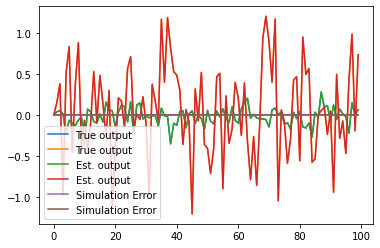

In [6]:
x0_train = data['init_state_train'][0]
u_train =  data['u_train'][0]
y_train =  data['y_train'][0]

y_est_train = model.Simulation(x0_train,u_train)
y_est_train = np.array(y_est_train)  

plt.plot(y_train,label='True output')                                              # Plot True data
plt.plot(y_est_train,label='Est. output')                                          # Plot Model Output
plt.plot(y_train-y_est_train,label='Simulation Error')                             # Plot Error between model and true system (its almost zero)
plt.legend()
plt.show()

The fit might be good or not, that depends if the solver was able to find a good solution from the (randomly) initially chosen model parameters. Running the identification procedure multiple times, will eventually result in a model with good fit.

Let's also check the fit on a set of data the model has not seen during parameter estimation:

In [ ]:
x0_val = data['init_state_val'][0]
u_val =  data['u_val'][0]
y_val =  data['y_val'][0]

y_est_val = model.Simulation(x0_val,u_val)
y_est_val = np.array(y_est_val)  

plt.plot(y_val,label='True output')                                              # Plot True data
plt.plot(y_est_val,label='Est. output')                                          # Plot Model Output
plt.plot(y_val-y_est_val,label='Simulation Error')                               # Plot Error between model and true system (its almost zero)
plt.legend()
plt.show()

###  ModelTraining()

ModelTraining() automizes the procedure described above. It calls ModelParameterEstimation() multiple times and evaluates the estimated models on a set of validation data. Then it returns a pandas datafram containing the loss of each of the identified models on the validation data as well as the corresponding parameters. The user can then simply pick the model with the least validation error.

For the purpose of speeding up this tutorial, the number of maximum iterations will be set to the rather small value of 500. The default value is 1000. Options can be passed to the solver, which is ipopt in this case, via a dictionary. All possible options are documented under https://coin-or.github.io/Ipopt/OPTIONS.html 

In [ ]:
s_opts = {"max_iter": 1000, "print_level":0}
p_opts = None
identification_results = ModelTraining(model,data,initializations = 5, p_opts=None, s_opts=s_opts)

The user can now inspect the results 

In [ ]:
print(identification_results)

and assign the parameters which yield the best fit to their model. If the second initialization was most successful one would do

In [ ]:
model.Parameters = identification_results.loc[2,'params']

to assign these parameters to the model.

### HyperParameterPSO()

In the example above the data generating system is known to be nonlinear, second order and both of the states are measured. The model approach was chosen appropriately: The MLP is a nonlinear model and it takes $\boldsymbol{u}$ and one time delay of $\boldsymbol{y}$ as input. However, if no knowledge regarding the order of the system or the severeness of the nonlinearity are available it is very hard to choose an appropriate model. For this purpose, a particle swarm optimization was implemented. HyperParameterPSO() searches, within bounds given by the user, for the optimal model structure.

The MLP class has three attributes: dim_u, which specifies the dimension of the input, dim_x which specifies the dimension of the output and dim_hidden, which specifies the number of neurons in the hidden layer. The particle swarm optimizer will be used, to find the smallest number of dim_hidden between 1 and 10 necessary to obtain a good model fit:

In [ ]:
param_bounds = {'dim_hidden':np.array([1,10])}
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.4, 'k':5, 'p':1}
n_particles = 5
initializations = 2
s_opts = {"max_iter": 100, "print_level":0}

In [ ]:
PSO_results = HyperParameterPSO(model,data,param_bounds,n_particles, options,initializations,p_opts=p_opts,s_opts=s_opts)

HyperParameterPSO()returns a pandas dataframe containing the best validation loss of each particle and the corresponding model parameters.

In [ ]:
print(PSO_results)

If, e.g. satisfactory results have been achieved with three neurons in the hidden layer (dim_hidden=3), then the user first has to create a model with the appropriate structure:

In [ ]:
new_model = MLP(dim_u=2,dim_x=2,dim_hidden=3,name='MLP_dim_hidden_3')

and then assign the corresponding parameters

In [ ]:
new_model.Parameters = PSO_results.loc[3,'model_params']

It is noticable, that the PSO did return Nan as result for the particles with nine and ten neurons in the hidden layer. This can happen, if the optimization fails, e.g. due to an unfavourable initialization. In this case however, the reason lies in the binary encoding of the discrete optimization variable dim_hidden: In order to encode 8 different values, a binary number with 3 digits is necessary. The binary encoding of 10 different values requires 4 digits, but this would also make 11 and 12 viable solutions, which lie outside of the user-specified bounds. So the PSO automatically reduces the solution space in order to guarantee that the user specified bounds are respected.